#  Building a Text/Topic Classifier with Transfer Learning

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
#torch.cuda.empty_cache() 

## Preparing the Data

Download the dataset from here: http://qwone.com/~jason/20Newsgroups/

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (ie. `comp.sys.ibm.pc.hardware` / `comp.sys.mac.hardware`), while others are highly unrelated (ie. `misc.forsale` / `soc.religion.christian`). Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

	comp.graphics
	comp.os.ms-windows.misc
	comp.sys.ibm.pc.hardware
	comp.sys.mac.hardware
	comp.windows.x
	rec.autos
	rec.motorcycles
	rec.sport.baseball
	rec.sport.hockey
	sci.crypt
	sci.electronics
	sci.med
	sci.space
	misc.forsale
	talk.politics.misc
	talk.politics.guns
	talk.politics.mideast
	talk.religion.misc
	alt.atheism
    soc.religion.christian
    
We use the "bydate" version, sorted by date into training (60%) and test (40%) sets. It's more realistic because the train and test sets are separated in time. It also has been cleaned, it does not include cross-posts and duplicates, and does not include newsgroup-identifying headers (Xref, Newsgroups, Path, Followup-To, Date). In total there are **18846 documents**.

In [3]:
DATA_PATH = Path('../datasets/20news')
DATA_PATH.mkdir(exist_ok=True)

### Data Pre-Processing

*These steps must be performed only once -- specific to the dataset we're using*.

We need to pre-process the dataset first:
1. Rename all files without extension to `.txt`, so they can be "seen" by fastai library helpers.

In [ ]:
import codecs

In [ ]:
for path, subdirs, files in os.walk(DATA_PATH):
    for name in files:
        fullpath = pathlib.PurePath(path, name)
        os.rename(fullpath, str(fullpath) + '.txt')

2. Convert ANSI files to UTF-8 encoding, to avoid errors while loading them.

In [ ]:
for path, subdirs, files in os.walk(DATA_PATH):
    for name in files:
        fullpath = pathlib.PurePath(path, name)
        try:
            #read input file
            with codecs.open(fullpath, 'r', encoding = 'utf8') as file:
                lines = file.read()
        except:
            with codecs.open(fullpath, 'r', encoding = 'ansi') as file:
                lines = file.read()
            #write output file
            with codecs.open(fullpath, 'w', encoding = 'utf8') as file:
                file.write(lines)  

We can now load our data:

In [ ]:
classes = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
           'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
           'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space',
           'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc',
           'talk.religion.misc']

In [ ]:
data_clas = TextClasDataBunch.from_folder(DATA_PATH, train='20news-bydate-train', valid='20news-bydate-test', classes=classes)

In [9]:
data_clas.show_batch()

text,target
xxbos xxmaj subject : roman.bmp 01 / xxunk response to the requests for cool bitmaps i am posting one . \n xxmaj from : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj reply - xxmaj to : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj distribution : usa \n xxmaj organization : xxmaj university of xxmaj south xxmaj dakota \n xxmaj lines : 978 \n\n\n xxmaj due to the resolution and size,comp.os.ms-windows.misc
xxbos xxmaj from : chongo@toad.com ( xxmaj landon xxup c. xxmaj noll ) \n xxmaj subject : xxmaj reposting : 10th xxmaj international xxmaj obfuscated c xxmaj code xxmaj contest rules ( 2 of 2 ) \n xxmaj expires : 8 xxmaj may 93 00:00:00 xxup gmt \n xxmaj reply - xxmaj to : chongo@toad.com ( xxmaj landon xxup c. xxmaj noll ) \n xxmaj distribution : world \n xxmaj,comp.windows.x
xxbos xxmaj subject : roman.bmp 09 / 14 xxrep 12 - xxmaj part 9 of 14 xxrep 12 - \n xxmaj from : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj reply - xxmaj to : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj distribution : usa \n xxmaj organization : xxmaj university of xxmaj south xxmaj dakota \n xxmaj lines : 958 \n\n\n xxup max > ' xxwrep 2 xxup ax,comp.os.ms-windows.misc
"xxbos xxmaj from : dbl@visual.com ( xxmaj david xxup b. xxmaj lewis ) \n xxmaj subject : comp.windows.x xxmaj frequently xxmaj asked xxmaj questions ( xxup faq ) 1 / 5 \n xxmaj summary : useful information about the x xxmaj window xxmaj system \n xxmaj reply - xxmaj to : faq%craft@uunet.uu.net ( x xxup faq maintenance address ) \n xxmaj organization : xxup visual , xxmaj inc. \n xxmaj",comp.windows.x
xxbos xxmaj subject : roman.bmp 11 / 14 \n xxmaj from : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj reply - xxmaj to : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj distribution : usa \n xxmaj organization : xxmaj university of xxmaj south xxmaj dakota \n xxmaj lines : 956 \n\n\n\n xxrep 12 - xxmaj part 11 of 14 xxrep 12 - \n xxup xxunk xxwrep 2 xxup g9v=,comp.os.ms-windows.misc


Being the line before a bit long, in the future we want to load quickly the final transformed results. So, we can save the work so far by using the following cell:

In [ ]:
data_clas.save('tmp')

and loading back with this one:

In [ ]:
data_clas = TextClasDataBunch.load(DATA_PATH, 'tmp', bs=bs)

In [ ]:
doc(TextClasDataBunch)

## Language Model Fine-Tuning

We are **not** going to train a model that classifies the documents from scratch.

We'll use a model **pretrained** on a bigger dataset (a cleaned subset of Wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)).  
That model has been trained to guess the next word, its input being the previous ones.

We are going to use that 'knowledge' of the English language to build our classifier, but first, we need to **fine tune** the pretrained model to our particular dataset. Because the English of the documents in the newsgroup isn't the same as the English of Wikipedia, we'll need to adjust the parameters of our model. In addition, there might be some words extremely common in that dataset that were barely present in Wikipedia, and therefore might no be part of the vocabulary the model was trained on.

In [4]:
bs = 32

Let's create our data object with the Data Block API:

In [5]:
data_lm = (TextList.from_folder(DATA_PATH)
            .filter_by_folder(include=['20news-bydate-train', '20news-bydate-test']) 
            .random_split_by_pct(0.1) 
            .label_for_lm()
            .databunch(bs=bs))
data_lm.save('tmp_lm')

From now on, if we want to load quickly the final results, we can use the following cell:

In [5]:
data_lm = TextLMDataBunch.load(DATA_PATH, 'tmp_lm', bs=bs)

We use a special kind of `TextDataBunch` for the language model, that **ignores the labels**, shuffles the texts at each epoch before concatenating them all together, and sends batches that **read that text in order with inferred targets that are the next word in the sentence**.

In [ ]:
doc(TextLMDataBunch)

In [ ]:
data_lm.show_batch()

In [ ]:
doc(Learner)

We can then put this in a Learner object very easily, with a model loaded with pretrained weights.

In [6]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

 Pre-trained models will be downloaded the first time you'll execute the previous line, and stored by default in `~/.fastai/models/` (or elsewhere if you changed the config file).

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


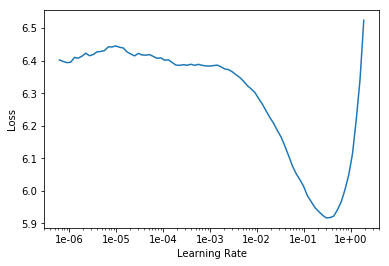

In [8]:
learn.recorder.plot(skip_end=8)

In [9]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.974687,3.748984,0.344966


In [10]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [11]:
learn.unfreeze()

In [12]:
learn.fit_one_cycle(15, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.576311,3.525707,0.373544
2,3.225300,3.383976,0.397529
3,3.176068,3.281241,0.416279
4,3.035239,3.200302,0.430831
5,2.908198,3.132305,0.442265
6,2.926290,3.071579,0.452932
7,2.680589,3.020365,0.461733
8,2.666873,2.981960,0.467910
9,2.619888,2.950953,0.474830
10,2.487435,2.925591,0.480116


In [13]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [8]:
TEXT = "Subject:"
N_WORDS = 100
N_SENTENCES = 3

In [9]:
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8, min_p=0.002) for _ in range(N_SENTENCES)))

Subject: xxmaj how many people can use a group of 
 xxmaj israelis to view their food for another day ? 
  4 : xxmaj how did you decide if the xxmaj government should buy a | 
  xxmaj who | xxmaj the xxmaj secret xxmaj agent ? xxmaj how do they know that you are n't using the 
  xxmaj national xxmaj security xxmaj agency ? ( xxmaj no , i do n't know that they are just 
  trying to crack the phone ? ) xxmaj if the xxmaj security xxmaj committee , the 
  xxmaj federal xxmaj reserve

Subject: xxmaj re : xxmaj new xxmaj study xxmaj out xxmaj on xxmaj gay xxmaj percentage 
 xxmaj organization : xxmaj university of xxmaj arizona xxmaj computer xxmaj science xxmaj dept . 
 xxmaj lines : 12 

 xxmaj when you start up the xxmaj zionist xxmaj federation ( 1 - 800 - , or ' 65 - ' xxmaj branch 
  the xxmaj church of xxmaj kent xxmaj campus - xxmaj xxmaj news xxmaj gateway ) , you can use a xxmaj greek 
  language to give you any information on what you believe . xxmaj the 
  xxup la

Subject: xxma

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [18]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a **new** DataBunch that only grabs the labelled data and keeps those labels. We need to perform the pre-processing to build our newsgroup databunch in such a way that *the vocabulary used to fine-tune the language model is the same*.

So, first, load the fine-tuned language model dataset:

In [5]:
data_lm = TextLMDataBunch.load(DATA_PATH, bs=bs, cache_name='tmp_lm')

and use its vocabulary to prepare the classification dataset:

In [6]:
classes = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
           'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
           'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space',
           'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc',
           'talk.religion.misc']

In [21]:
data_clas = TextClasDataBunch.from_folder(DATA_PATH, train='20news-bydate-train', valid='20news-bydate-test', classes=classes, vocab=data_lm.vocab)

By executing this line, a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [22]:
data_clas.save('tmp_clas')

Next time we launch this notebook, we can skip the cell above that took a bit of time and load the final results like this:

In [7]:
data_clas = TextClasDataBunch.load(DATA_PATH, 'tmp_clas', bs=bs)

In [23]:
data_clas.show_batch()

text,target
xxbos xxmaj subject : roman.bmp 01 / 14in response to the requests for cool bitmaps i am posting one . \n xxmaj from : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj reply - xxmaj to : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj distribution : usa \n xxmaj organization : xxmaj university of xxmaj south xxmaj dakota \n xxmaj lines : 978 \n\n\n xxmaj due to the resolution and size,comp.os.ms-windows.misc
"xxbos xxmaj from : xxunk ( xxmaj michael xxmaj phelps ) \n xxmaj subject : xxmaj re : xxmaj need xxmaj senate xxmaj bill numbers and xxmaj house xxmaj resolution numbers \n xxmaj originator : mjp@bwa.kgn.ibm.com \n xxmaj reply - xxmaj to : mjp@vnet.ibm.com ( xxmaj michael xxup j. xxmaj phelps ) \n xxmaj disclaimer : xxmaj this posting represents the poster 's views , not necessarily those of xxup",talk.politics.guns
xxbos xxmaj from : ld231782@longs.lance.colostate.edu ( xxup l. xxmaj detweiler ) \n xxmaj subject : xxmaj privacy & xxmaj anonymity on the xxmaj internet xxup faq ( 2 of 3 ) \n xxmaj supersedes : < net - privacy / xxunk > \n xxmaj organization : xxup tmp xxmaj enterprises \n xxmaj lines : xxunk \n xxmaj expires : 21 xxmaj may 1993 xxunk xxup gmt \n xxmaj reply -,sci.crypt
"xxbos xxmaj from : bgrubb@dante.nmsu.edu ( xxup grubb ) \n xxmaj subject : xxmaj mac & xxup ibm xxmaj info - xxmaj version xxunk \n xxmaj organization : xxmaj new xxmaj mexico xxmaj state xxmaj university , xxmaj las xxmaj cruces , xxup nm \n xxmaj lines : 753 \n xxmaj distribution : world \n xxup nntp - xxmaj posting - xxmaj host : dante.nmsu.edu \n\n { xxmaj send follow",comp.sys.mac.hardware
xxbos xxmaj subject : roman.bmp 04 / 14 \n xxmaj from : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj reply - xxmaj to : pwiseman@salmon.usd.edu ( xxmaj cliff ) \n xxmaj distribution : usa \n xxmaj organization : xxmaj university of xxmaj south xxmaj dakota \n xxmaj lines : 958 \n\n\n xxrep 12 - xxmaj part 4 of 14 xxrep 12 - \n xxup xxunk < xxup xxunk <,comp.os.ms-windows.misc


Let's verify that language model vocabulary is the same as the classification vocabulary:

In [24]:
len(data_lm.vocab.itos)

57331

In [25]:
len(data_clas.vocab.itos)

57331

In [26]:
data_lm.vocab.itos[:30]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '\n',
 ',',
 '.',
 'the',
 '>',
 ':',
 'to',
 'of',
 '-',
 'a',
 'and',
 ')',
 '\n\n',
 '(',
 'i',
 'in',
 'is',
 'that',
 '\n ',
 '"',
 'it',
 '/']

In [27]:
data_clas.vocab.itos[:30]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '\n',
 ',',
 '.',
 'the',
 '>',
 ':',
 'to',
 'of',
 '-',
 'a',
 'and',
 ')',
 '\n\n',
 '(',
 'i',
 'in',
 'is',
 'that',
 '\n ',
 '"',
 'it',
 '/']

We can then create a model to classify those documents and load the encoder we saved before.

In [18]:
doc(text_classifier_learner)

In [8]:
drop_mult = 0.5

In [9]:
learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
doc(fit_one_cycle)

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


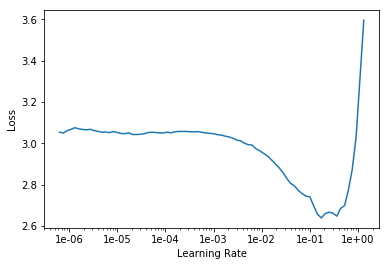

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.283231,0.626813,0.806559


In [33]:
learn.save('first')

In [ ]:
learn.load('first');

In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.721625,0.563073,0.833776


In [35]:
learn.save('second')

In [8]:
learn.load('second');

In [9]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.608820,0.519886,0.853293


In [10]:
learn.save('third')

In [8]:
learn.load('third');

In [9]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.510231,0.508746,0.862188
2,0.482355,0.500396,0.869357


In [ ]:
learn.save('final')

### Test the final classifier

In [12]:
learn.load('final')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (11314 items)
[Category alt.atheism, Category alt.atheism, Category alt.atheism, Category alt.atheism, Category alt.atheism]...
Path: .
x: TextList (11314 items)
[Text xxbos xxmaj from : mathew < mathew@mantis.co.uk > 
 xxmaj subject : xxmaj alt . xxmaj atheism xxup faq : xxmaj atheist xxmaj resources 
 xxmaj summary : xxmaj books , addresses , music -- anything related to atheism 
 xxmaj keywords : xxup faq , atheism , books , music , fiction , addresses , contacts 
 xxmaj expires : xxmaj thu , 29 xxmaj apr 1993 xxunk xxup gmt 
 xxmaj distribution : world 
 xxmaj organization : xxmaj mantis xxmaj consultants , xxmaj cambridge . xxup uk . 
 xxmaj supersedes : < xxunk > 
 xxmaj lines : 290 

 xxmaj archive - name : atheism / resources 
 xxmaj alt - atheism - archive - name : resources 
 xxmaj last - modified : 11 xxmaj december 1992 
 xxmaj version : 1.0 

  xxmaj atheist xxmaj resources 

  xxmaj addresses of xxmaj at

In [13]:
learn.show_results()

text,target,prediction
"xxbos xxmaj from : dbushong@wang.com ( xxmaj dave xxmaj bushong ) \n xxmaj subject : xxmaj re : xxmaj more xxmaj cool xxup bmp files ? ? \n xxmaj organization : xxmaj wang xxmaj labs , xxmaj lowell xxup ma , xxup usa \n xxmaj distribution : usa \n xxmaj lines : xxunk \n\n xxunk ( xxmaj owen xxmaj adair ) writes : \n\n > xxmaj in article < 1993apr20.173506.2288@dlss2",comp.os.ms-windows.misc,comp.os.ms-windows.misc
xxbos xxmaj from : nfotis@ntua.gr ( xxmaj nick xxup c. xxmaj fotis ) \n xxmaj subject : ( 27 xxmaj apr 93 ) xxmaj computer xxmaj graphics xxmaj resource xxmaj listing : xxup weekly [ part 1 / 3 ] \n xxmaj lines : xxunk \n xxmaj reply - xxmaj to : nfotis@theseas.ntua.gr ( xxmaj nick ( xxmaj nikolaos ) xxmaj fotis ) \n xxmaj organization : xxmaj national xxmaj,comp.graphics,comp.graphics
xxbos xxmaj from : nfotis@ntua.gr ( xxmaj nick xxup c. xxmaj fotis ) \n xxmaj subject : ( 27 xxmaj apr 93 ) xxmaj computer xxmaj graphics xxmaj resource xxmaj listing : xxup weekly [ part 3 / 3 ] \n xxmaj lines : xxunk \n xxmaj reply - xxmaj to : nfotis@theseas.ntua.gr ( xxmaj nick ( xxmaj nikolaos ) xxmaj fotis ) \n xxmaj organization : xxmaj national xxmaj,comp.graphics,comp.graphics
"xxbos xxmaj from : dcr@mail.ast.cam.ac.uk ( xxmaj derek xxup c. xxmaj richardson ) \n xxmaj subject : xrastool 1.0 part 2 / 2 \n xxmaj keywords : animation xview raster \n xxmaj nntp - xxmaj posting - xxmaj host : ioas09.ast.cam.ac.uk \n xxmaj reply - xxmaj to : dcr@mail.ast.cam.ac.uk \n xxmaj organization : xxmaj institute of xxmaj astronomy , xxmaj cambridge \n xxmaj lines : 738 \n\n part 2 /",comp.windows.x,comp.os.ms-windows.misc
"xxbos xxmaj from : lee@sq.sq.com ( xxmaj liam xxup r. xxup e. xxmaj quin ) \n xxmaj subject : xxup open xxup look xxup gui frequently asked questions \n xxmaj organization : softquad xxmaj inc. , xxmaj toronto , xxmaj canada \n xxmaj expires : 10 xxmaj jun 1993 xxunk xxup gmt \n xxmaj lines : 1231 \n\n\n xxmaj frequently - asked questions about the xxup open xxup look xxmaj",comp.windows.x,comp.windows.x


Let's try with custom text, I got the following examples from web articles:

Computer Graphics

In [14]:
text = "GeForce RTX graphics cards are the fastest in the world, giving PC gamers the very best framerates and experiences in each and every game. Now, RTX is coming to laptops, starting with over 40 new GeForce RTX laptops, in 100-plus configurations, from partners around the world. And like desktop GeForce RTX graphics cards, RTX laptops have the hardware required for real-time ray tracing and AI-enhanced graphics, enabling you to experience immersive, lifelike visual effects anywhere, anytime."
learn.predict(text)

d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category comp.graphics,
 tensor(1),
 tensor([3.8907e-04, 6.9232e-01, 2.0178e-02, 2.5804e-01, 2.3603e-03, 9.9421e-04,
         1.0496e-02, 1.1623e-04, 1.7132e-04, 7.0885e-05, 2.9429e-04, 9.9567e-04,
         1.2701e-02, 1.8646e-04, 2.5873e-04, 1.4428e-04, 1.2017e-04, 2.8042e-05,
         6.5282e-05, 7.5731e-05]))

Baseball

In [15]:
text = "The Brewers had no such qualms. They recognized that Grandal perennially ranked among the best catchers in baseball at framing pitches for strikes. They also saw a hitter who made up for often low batting averages with a strong batting eye and solid power numbers. In fact, while J.T. Realmuto was the clear leader among catchers last season, Grandal checked in at No. 2 by Wins Above Replacement."
learn.predict(text)

d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category rec.sport.baseball,
 tensor(9),
 tensor([1.7830e-04, 8.0381e-05, 7.0424e-05, 1.1489e-04, 8.9022e-05, 9.0832e-06,
         1.9189e-04, 1.2210e-04, 6.5017e-05, 9.9591e-01, 1.6425e-03, 3.2412e-04,
         5.7363e-05, 2.4132e-04, 6.0795e-05, 3.8582e-04, 3.4465e-04, 1.5301e-05,
         4.5334e-05, 5.0371e-05]))

Hockey

In [16]:
text = "Mark Giordano had two goals and an assist in his 800th career game and the Calgary Flames defeated the Arizona Coyotes 7-1 Sunday night. Giordano, the Flames' captain, has 47 points (nine goals, 38 assists) in 45 games this season, second among NHL defensemen and five points behind San Jose's Brent Burns. Matthew Tkachuk scored two goals, and Sean Monahan, Johnny Gaudreau and Sam Bennett also scored for Calgary, which has won five straight and improved to 8-1-1 in its last 10. The Flames lead the Pacific Division by three points over the Sharks. Gaudreau also had an assist, extending his point streak to eight games (eight goals, 10 assists). With 69 points, he ranks second in the league in scoring, six points back of Tampa Bay's Nikita Kucherov."
learn.predict(text)

d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category rec.sport.hockey,
 tensor(10),
 tensor([1.1231e-06, 8.4566e-06, 2.1121e-06, 1.4703e-05, 7.1197e-07, 1.4848e-06,
         9.1880e-06, 2.3402e-06, 1.0409e-06, 5.8092e-05, 9.9988e-01, 3.9335e-06,
         2.4878e-06, 6.0395e-07, 6.9496e-07, 2.0077e-06, 4.8088e-06, 2.3729e-08,
         4.0907e-07, 1.2709e-06]))

In [17]:
text = "Mike Smith got the start in the nets for Calgary in place of red-hot David Rittich. He made 22 saves and improved to 13-9-1. Adin Hill had 19 saves for the Coyotes and fell to 7-5. Calgary surged in front on two goals 68 seconds apart late in the first period. At 16:51, Giordano got the puck in the corner and fired a shot into the top corner from a sharp angle."
learn.predict(text)

d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category rec.sport.hockey,
 tensor(10),
 tensor([1.2825e-04, 6.9544e-05, 6.1332e-05, 2.0961e-04, 6.6327e-05, 3.3994e-05,
         5.8298e-04, 1.7557e-04, 1.9445e-04, 1.2326e-02, 9.8522e-01, 1.4812e-04,
         9.8107e-05, 5.6891e-05, 2.9520e-05, 3.7244e-05, 4.3986e-04, 5.4630e-06,
         6.5544e-05, 5.4401e-05]))

Cars

In [18]:
text = "Our first impression is that it feels like a fairly mature car; Toyota is billing this car as a premium GT set up for occasional track use. The automaker notes that this is the first global model developed by Toyota Gazoo Racing, which put its stamp on the car throughout the entire development process (and also put a small GR badge on the rear of the car, just below its lightweight composite liftback)."
learn.predict(text)

d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category rec.autos,
 tensor(7),
 tensor([5.3952e-05, 6.2523e-05, 9.0237e-05, 5.5609e-04, 1.4624e-04, 5.6928e-06,
         9.3821e-04, 9.9688e-01, 5.9993e-04, 4.7132e-06, 2.0234e-05, 4.2557e-05,
         1.8133e-04, 2.8606e-05, 2.6770e-06, 2.4692e-04, 7.0102e-05, 3.9456e-06,
         3.4894e-05, 2.7372e-05]))

If you want more details, you can obtain a confusion matrix like this:

In [19]:
from fastai.vision import ClassificationInterpretation

In [ ]:
doc(ClassificationInterpretation)

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

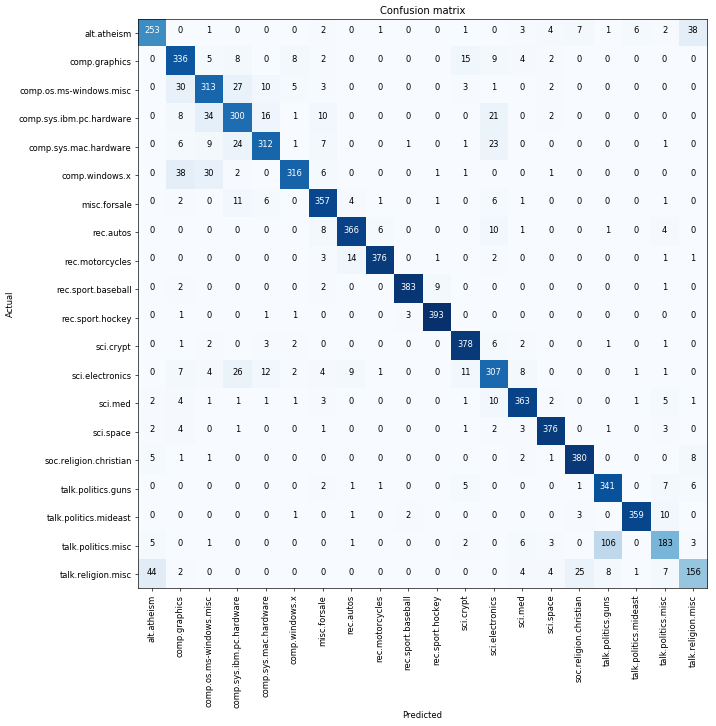

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

The most confused ones:

In [22]:
interp.most_confused(min_val=20)

[('talk.politics.misc', 'talk.politics.guns', 106),
 ('talk.religion.misc', 'alt.atheism', 44),
 ('alt.atheism', 'talk.religion.misc', 38),
 ('comp.windows.x', 'comp.graphics', 38),
 ('comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 34),
 ('comp.os.ms-windows.misc', 'comp.graphics', 30),
 ('comp.windows.x', 'comp.os.ms-windows.misc', 30),
 ('comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 27),
 ('sci.electronics', 'comp.sys.ibm.pc.hardware', 26),
 ('talk.religion.misc', 'soc.religion.christian', 25),
 ('comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 24),
 ('comp.sys.mac.hardware', 'sci.electronics', 23),
 ('comp.sys.ibm.pc.hardware', 'sci.electronics', 21)]

If you want to know the items with the highest loss:

In [23]:
tl_val, tl_idx = interp.top_losses(10)

In [24]:
from IPython.display import display, HTML
max_len=100
items = [['text', 'prediction', 'actual', 'loss', 'probability']]
for i, idx in enumerate(tl_idx):
    txt, target = learn.data.valid_ds[idx]
    pred, cls_idx, probs = learn.predict(txt)
    loss = float(tl_val[i])
    prob = to_np(probs[cls_idx])
    txt_x = ' '.join(txt.text.split(' ')[:max_len])
    items.append([str(txt_x), str(pred), str(target), str(loss), str(prob)])
display(HTML(text2html_table(items, ([80,10,10]))))

d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
d:\users\gianni\projects\ps-fastai\venv_psfastai10\lib\site-packages\fastai\torch_core.py:72: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Te

text,prediction,actual,loss,probability
xxbos xxmaj from : gtj@goanna.cs.rmit.oz.au ( xxmaj glenn t xxmaj jayaputera ) \n xxmaj subject : xxmaj how to change the cluster size \n xxmaj organization : xxup rmit xxmaj department of xxmaj computer xxmaj science \n xxmaj lines : 5 \n\n xxmaj wondering if somebody could tell me if we can change the cluster size of \n my xxup ide drive . xxmaj normally i can do it with xxmaj norton 's xxmaj xxunk on xxup mfm / xxup rll drives \n but dunno if i can on xxup ide too . \n\n glenn xxmaj jayaputera \n,comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.hardware,15.359896659851074,0.8889912
"xxbos xxmaj from : coutsoft@cheshire.oxy.edu ( xxmaj michael xxmaj coutsoftides ) \n xxmaj subject : 386dx 20mhz motherboard for sale \n xxmaj organization : xxmaj occidental xxmaj college , xxmaj los xxmaj angeles , xxup ca 90041 xxup usa . \n xxmaj lines : 1 \n\n\n",misc.forsale,misc.forsale,15.254006385803223,0.9696714
"xxbos xxmaj from : eeb1@quads.uchicago.edu ( xxup e. xxmaj elizabeth xxmaj bartley ) \n xxmaj subject : xxmaj no cost to gun waiting periods ? ? ? \n xxmaj reply - xxmaj to : eeb1@midway.uchicago.edu \n xxmaj organization : xxmaj university of xxmaj chicago \n xxmaj lines : 35 \n\n xxmaj in article < xxunk > \n xxunk ( xxmaj carl xxmaj aron ) writes : \n\n > i 'm not sure were this thread has been before i popped in , but i 've never \n > thought of waiting periods as having anything to do with training or",talk.politics.guns,talk.politics.guns,13.785503387451172,0.9767377
"xxbos xxmaj from : spl@pitstop.ucsd.edu ( xxmaj steve xxmaj lamont ) \n xxmaj subject : xxmaj re : xxup cgm xxmaj files \n xxmaj organization : xxmaj university of xxmaj calif. , xxmaj san xxmaj diego / xxmaj microscopy and xxmaj imaging xxmaj resource \n xxmaj lines : 32 \n xxup nntp - xxmaj posting - xxmaj host : pitstop.ucsd.edu \n\n xxmaj in article < xxunk > xxunk ( xxmaj xxunk xxmaj xxunk xxmaj meyer ) writes : \n > xxmaj the only book i 've found on the xxup cgm format , is "" xxup cgm and xxup cgi",comp.graphics,comp.graphics,12.881021499633789,0.999057
"xxbos xxmaj from : mls@panix.com ( xxmaj michael xxmaj siemon ) \n xxmaj subject : eros in xxup lxx : concluding xxunk note \n xxmaj organization : xxup panix xxmaj public xxmaj access xxmaj unix , xxup nyc \n xxmaj lines : 58 \n\n xxmaj this might be better directed to xxunk , which i have begun \n reading , but since my earlier notes were posted to this forum , i will \n conclude here as well . a week ago , i managed to find time to consult \n a xxmaj septuagint xxmaj concordance and a xxup lxx",soc.religion.christian,soc.religion.christian,12.577790260314941,0.8083428
"xxbos xxmaj from : guyd@austin.ibm.com ( xxmaj guy xxmaj dawson ) \n xxmaj subject : xxmaj re : xxup dx50 vs xxup dx266 \n xxmaj originator : guyd@pal500.austin.ibm.com \n xxmaj organization : xxup ibm xxmaj austin \n xxmaj lines : 54 \n\n\n xxmaj in article < xxunk . ins.cwru.edu > , ab245@cleveland . xxmaj freenet . xxmaj edu ( xxmaj sam xxmaj latonia ) writes : \n > \n > \n > \n > \n > xxmaj article # xxunk ( xxunk is last ) : \n > > xxmaj newsgroups : comp.sys.ibm.pc.hardware \n > xxmaj from : arnolm2@aix.rpi.edu (",comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.hardware,12.30131721496582,0.92262715
xxbos xxmaj from : xxunk ( xxup g. xxmaj scott xxmaj xxunk ) \n xxmaj subject : xxmaj re : xxup help 8088 / 80286 xxup advice \n xxmaj organization : xxmaj university of xxmaj illinois at xxmaj urbana \n xxmaj lines : 20 \n\n < xxunk > writes : \n\n > i own an 8088 640 k clone which does all i want except run 1 game i want \n > to buy . xxmaj the game says it requires a 80286 with xxup xxunk xxmaj game tech . support \n > says game will run on 8088 but,comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.hardware,12.248899459838867,0.8927093
xxbos xxmaj from : xxunk ( xxmaj stephanie xxup e. xxmaj xxunk ) \n xxmaj subject : xxmaj re : xxup vhs xxmaj video for sale \n xxmaj organization : utexas xxmaj mail - to - xxmaj 